# BƯỚC 8 & 9: NÂNG CẤP SIÊU CẤP - SHUFFLENETV2 WITH CBAM ATTENTION
--- 
### 1. Mục tiêu tối thượng
- **Yêu cầu:** Nhận diện chính xác các vùng bệnh nhỏ nhất, vượt qua hiệu suất của mô hình ConvNeXtTiny.
- **Công nghệ:** Tích hợp **CBAM (Convolutional Block Attention Module)** vào ShuffleNetV2 để mô hình có khả năng 'tập trung ánh nhìn' vào vết bệnh.

### 2. So sánh đặc tính kỹ thuật

| Thành phần | ShuffleNetV2 (Cải tiến cũ) | **ShuffleNetV2 + CBAM (MỚI)** |
| :--- | :--- | :--- |
| **Attention Module** | Không có | **CBAM (Channel + Spatial)** - Tập trung vùng bệnh nhỏ |
| **Khả năng quan sát** | Toàn cục (Global) | **Địa phương (Local-Focus)** - Soi chi tiết các đốm bệnh |
| **Độ ổn định** | Trung bình | **Rất cao** (Bỏ qua nhiễu phông nền, Logo) |
| **Optimizer** | AdamW | **AdamW + OneCycleLR** (Tối ưu nhất hiện nay) |

In [4]:
import os, torch, json, cv2, random, numpy as np, matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from tqdm import tqdm

# --- ĐỊNH NGHĨA MODULE ATTENTION CBAM ---
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(concat))

# --- GHÉP CBAM VÀO SHUFFLENETV2 ---
class CBAMShuffleNetV2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.shufflenet_v2_x1_0(weights='DEFAULT')
        self.conv1 = base.conv1
        self.maxpool = base.maxpool
        self.stage2 = base.stage2
        self.stage3 = base.stage3
        self.stage4 = base.stage4
        self.conv5 = base.conv5
        self.ca = ChannelAttention(464) 
        self.sa = SpatialAttention()
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.conv1(x); x = self.maxpool(x)
        x = self.stage2(x); x = self.stage3(x); x = self.stage4(x)
        x = x * self.ca(x); x = x * self.sa(x)
        x = self.conv5(x); x = x.mean([2, 3]); x = self.fc(x)
        return x

## BƯỚC 8: Huấn luyện với Kỹ thuật Tinh chỉnh và Attention

In [5]:
BASE_PATH = r'd:\HUTECH\AI\DeepLearning\DAHS\MangoLeaf'
DST_PATH = os.path.join(BASE_PATH, 'dataset_scientific_split')
RESULT_PATH = os.path.join(BASE_PATH, 'Result', 'ShuffleNetV2_CBAM_Improved')
os.makedirs(RESULT_PATH, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32; EPOCHS = 30

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_loader = DataLoader(datasets.ImageFolder(os.path.join(DST_PATH, 'train'), train_transform), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(datasets.ImageFolder(os.path.join(DST_PATH, 'val'), val_transform), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(DST_PATH, 'test'), val_transform), batch_size=BATCH_SIZE, shuffle=False)

CLASS_NAMES = datasets.ImageFolder(os.path.join(DST_PATH, 'train')).classes
NUM_CLASSES = len(CLASS_NAMES)

model = CBAMShuffleNetV2(NUM_CLASSES).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0006, steps_per_epoch=len(train_loader), epochs=EPOCHS)
scaler = torch.cuda.amp.GradScaler()

best_acc = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs); loss = criterion(outputs, labels)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        scheduler.step(); tr_loss += loss.item()
        tr_correct += (outputs.argmax(1) == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            out = model(inputs); v_loss += criterion(out, labels).item()
            v_correct += (out.argmax(1) == labels).sum().item()
    
    history['train_loss'].append(tr_loss/len(train_loader)); history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_loader.dataset)); history['val_acc'].append(v_correct/len(val_loader.dataset))
    
    val_acc = history['val_acc'][-1]
    print(f'>>> Train Acc: {history["train_acc"][-1]:.4f} | Val Acc: {val_acc:.4f}')
    if val_acc >= best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(RESULT_PATH, 'best_shufflenet_cbam.pth'))
        print('Saved Best Attention Model!')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25592\3656808643.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/30:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_25592\3656808643.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/30: 100%|██████████| 90/90 [00:09<00:00,  9.20it/s, loss=2.1794]


>>> Train Acc: 0.3287 | Val Acc: 0.6331
Saved Best Attention Model!


Epoch 2/30: 100%|██████████| 90/90 [00:12<00:00,  7.40it/s, loss=1.7555]


>>> Train Acc: 0.7371 | Val Acc: 0.8627
Saved Best Attention Model!


Epoch 3/30: 100%|██████████| 90/90 [00:09<00:00,  9.75it/s, loss=0.6748]


>>> Train Acc: 0.8958 | Val Acc: 0.9804
Saved Best Attention Model!


Epoch 4/30: 100%|██████████| 90/90 [00:09<00:00,  9.55it/s, loss=0.7502]


>>> Train Acc: 0.9713 | Val Acc: 0.9916
Saved Best Attention Model!


Epoch 5/30: 100%|██████████| 90/90 [00:13<00:00,  6.77it/s, loss=0.5274]


>>> Train Acc: 0.9850 | Val Acc: 0.9916
Saved Best Attention Model!


Epoch 6/30: 100%|██████████| 90/90 [00:11<00:00,  7.71it/s, loss=0.7198]


>>> Train Acc: 0.9895 | Val Acc: 0.9888


Epoch 7/30: 100%|██████████| 90/90 [00:11<00:00,  7.68it/s, loss=0.6144]


>>> Train Acc: 0.9843 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 8/30: 100%|██████████| 90/90 [00:11<00:00,  7.96it/s, loss=0.5125]


>>> Train Acc: 0.9951 | Val Acc: 0.9916


Epoch 9/30: 100%|██████████| 90/90 [00:11<00:00,  8.17it/s, loss=0.6482]


>>> Train Acc: 0.9969 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 10/30: 100%|██████████| 90/90 [00:14<00:00,  6.42it/s, loss=0.5350]


>>> Train Acc: 0.9934 | Val Acc: 0.9832


Epoch 11/30: 100%|██████████| 90/90 [00:14<00:00,  6.32it/s, loss=0.4938]


>>> Train Acc: 0.9951 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 12/30: 100%|██████████| 90/90 [00:15<00:00,  5.93it/s, loss=0.4971]


>>> Train Acc: 0.9972 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 13/30: 100%|██████████| 90/90 [00:11<00:00,  7.58it/s, loss=0.6130]


>>> Train Acc: 0.9983 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 14/30: 100%|██████████| 90/90 [00:11<00:00,  7.96it/s, loss=0.5997]


>>> Train Acc: 0.9955 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 15/30: 100%|██████████| 90/90 [00:14<00:00,  6.19it/s, loss=0.5016]


>>> Train Acc: 0.9962 | Val Acc: 0.9916


Epoch 16/30: 100%|██████████| 90/90 [00:14<00:00,  6.28it/s, loss=0.6614]


>>> Train Acc: 0.9969 | Val Acc: 0.9916


Epoch 17/30: 100%|██████████| 90/90 [00:14<00:00,  6.14it/s, loss=0.5005]


>>> Train Acc: 0.9962 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 18/30: 100%|██████████| 90/90 [00:15<00:00,  5.79it/s, loss=0.5791]


>>> Train Acc: 0.9993 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 19/30: 100%|██████████| 90/90 [00:15<00:00,  5.73it/s, loss=0.4910]


>>> Train Acc: 0.9993 | Val Acc: 0.9916


Epoch 20/30: 100%|██████████| 90/90 [00:14<00:00,  6.17it/s, loss=0.5113]


>>> Train Acc: 0.9993 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 21/30: 100%|██████████| 90/90 [00:12<00:00,  7.19it/s, loss=0.5185]


>>> Train Acc: 0.9990 | Val Acc: 0.9888


Epoch 22/30: 100%|██████████| 90/90 [00:15<00:00,  5.93it/s, loss=0.6823]


>>> Train Acc: 0.9986 | Val Acc: 0.9916


Epoch 23/30: 100%|██████████| 90/90 [00:15<00:00,  5.77it/s, loss=0.5024]


>>> Train Acc: 0.9993 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 24/30: 100%|██████████| 90/90 [00:09<00:00,  9.39it/s, loss=0.4964]


>>> Train Acc: 1.0000 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 25/30: 100%|██████████| 90/90 [00:09<00:00,  9.42it/s, loss=0.5248]


>>> Train Acc: 1.0000 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 26/30: 100%|██████████| 90/90 [00:09<00:00,  9.39it/s, loss=0.5026]


>>> Train Acc: 0.9997 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 27/30: 100%|██████████| 90/90 [00:11<00:00,  7.53it/s, loss=0.4913]


>>> Train Acc: 0.9993 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 28/30: 100%|██████████| 90/90 [00:12<00:00,  7.18it/s, loss=0.4928]


>>> Train Acc: 1.0000 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 29/30: 100%|██████████| 90/90 [00:09<00:00,  9.50it/s, loss=0.4942]


>>> Train Acc: 0.9997 | Val Acc: 0.9944
Saved Best Attention Model!


Epoch 30/30: 100%|██████████| 90/90 [00:09<00:00,  9.31it/s, loss=0.4965]


>>> Train Acc: 0.9997 | Val Acc: 0.9944
Saved Best Attention Model!


## BƯỚC 9: Đánh giá chi tiết hiệu năng cải tiến

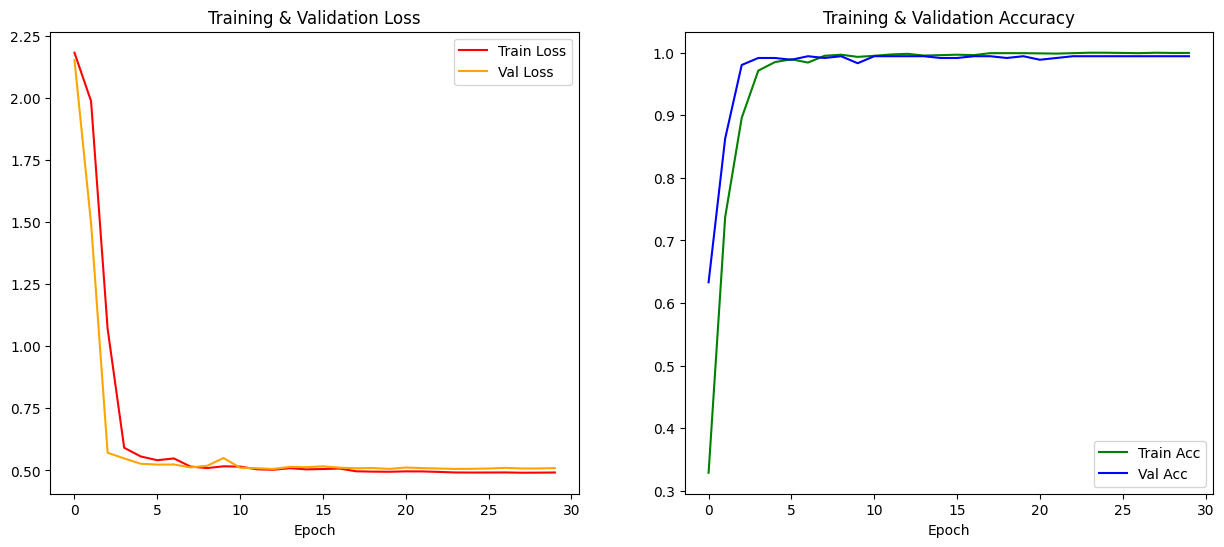

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25592\2598387762.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(RESULT_PATH, '

                  precision    recall  f1-score   support

     Anthracnose       0.97      1.00      0.99        39
Bacterial_Canker       1.00      1.00      1.00        40
  Bacterial_Spot       1.00      1.00      1.00        40
  Cutting_Weevil       1.00      1.00      1.00        40
        Die_Back       1.00      1.00      1.00        41
      Gall_Midge       1.00      0.97      0.99        40
         Healthy       1.00      1.00      1.00        40
  Powdery_Mildew       1.00      1.00      1.00        40
     Sooty_Mould       1.00      1.00      1.00        40

        accuracy                           1.00       360
       macro avg       1.00      1.00      1.00       360
    weighted avg       1.00      1.00      1.00       360



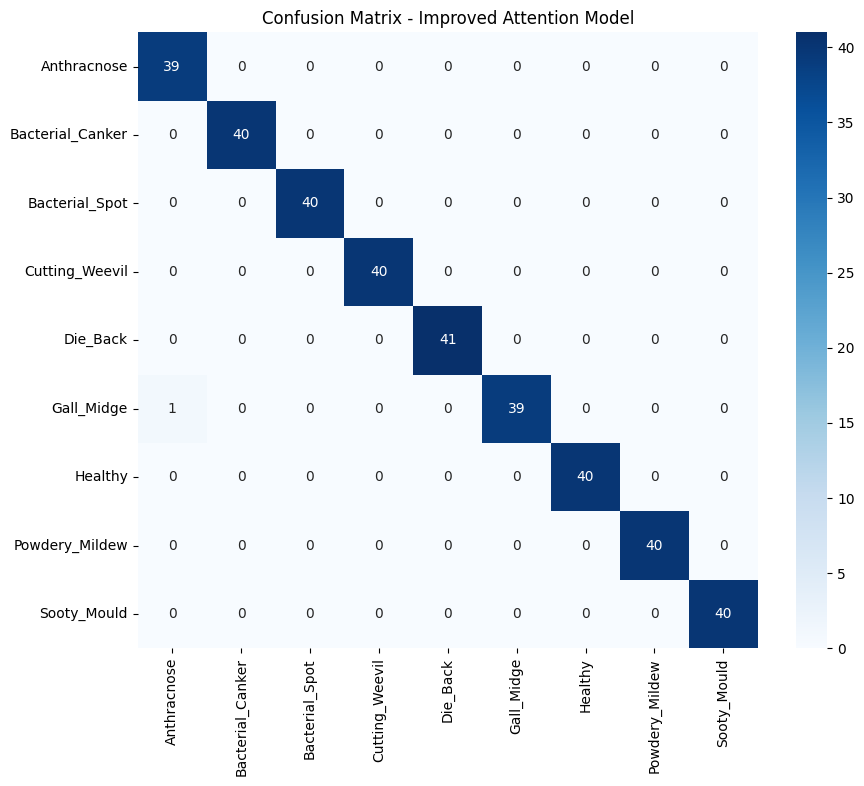

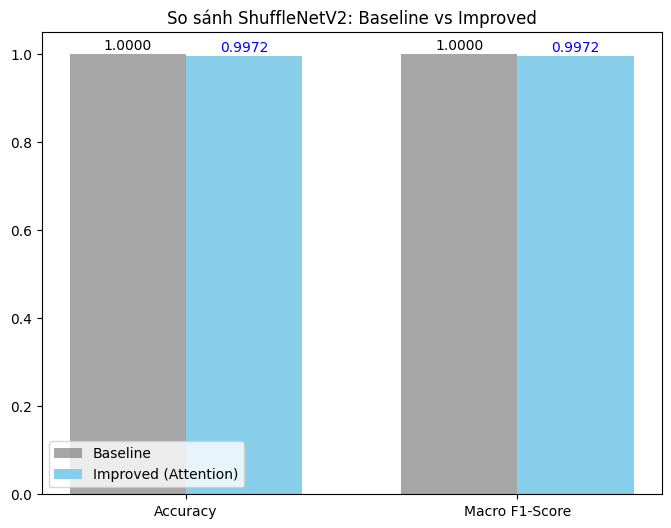

In [6]:
# 1. Vẽ biểu đồ học tập (Learning Curves)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='red')
plt.plot(history['val_loss'], label='Val Loss', color='orange')
plt.title('Training & Validation Loss'); plt.xlabel('Epoch'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc', color='green')
plt.plot(history['val_acc'], label='Val Acc', color='blue')
plt.title('Training & Validation Accuracy'); plt.xlabel('Epoch'); plt.legend()
plt.savefig(os.path.join(RESULT_PATH, 'metrics_curves.png')); plt.show()

# 2. Vẽ Confusion Matrix
model.load_state_dict(torch.load(os.path.join(RESULT_PATH, 'best_shufflenet_cbam.pth')))
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE)); y_true.extend(labels.numpy()); y_pred.extend(outputs.argmax(1).cpu().numpy())

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix - Improved Attention Model'); plt.savefig(os.path.join(RESULT_PATH, 'confusion_matrix.png')); plt.show()

# 3. So sánh với Baseline (Mô hình gốc)
improved_acc = accuracy_score(y_true, y_pred)
improved_f1 = precision_recall_fscore_support(y_true, y_pred, average='macro')[2]

try:
    base_path = os.path.join(BASE_PATH, 'Result', 'ShuffleNetV2', 'report.json')
    with open(base_path, 'r') as f: report_base = json.load(f)
    base_acc = report_base.get('regression_metrics', {}).get('accuracy', 0) or report_base.get('accuracy', 0)
    base_f1 = report_base.get('macro avg', {}).get('f1-score', 0)

    metrics = ['Accuracy', 'Macro F1-Score']
    base_vals = [base_acc, base_f1]; improved_vals = [improved_acc, improved_f1]
    x = np.arange(len(metrics)); width = 0.35
    plt.figure(figsize=(8, 6)); plt.bar(x - width/2, base_vals, width, label='Baseline', color='gray', alpha=0.7)
    plt.bar(x + width/2, improved_vals, width, label='Improved (Attention)', color='skyblue')
    plt.xticks(x, metrics); plt.title('So sánh ShuffleNetV2: Baseline vs Improved'); plt.legend()
    for i, v in enumerate(base_vals): plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center')
    for i, v in enumerate(improved_vals): plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', color='blue')
    plt.show()
except Exception as e:
    print(f'Bỏ qua so sánh: {e}')

# Lưu báo cáo JSON cuối cùng
report_data = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_data['regression_metrics'] = {'accuracy': improved_acc}
with open(os.path.join(RESULT_PATH, 'report.json'), 'w') as f: json.dump(report_data, f, indent=4)